In [16]:
import numpy as np
from numba import jit, njit, prange
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from tqdm.notebook import tqdm

In [17]:
np.random.seed(42)

NAME = 'assignment4'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


# Cellular Pots model

## Helper methods

In [18]:
@njit
def kronecker_delta(i, j):
    """Helper method for calculating Kronecker's delta.

    Args:
        i, j (int): compared values

    Returns:
        int: 1 if i equals j, 0 otherwise
    """    
    return int(i == j)

@njit
def celltype_from_id(sigma, n_types):
    """Helper method for obtaining cell type (tau) based on its ID (sigma).

    Args:
        sigma (int): cell ID
        n_types (int): number of different cell types in the simulation

    Returns:
        int: Cell type for the given cell ID.
    """    
    return (np.mod(sigma, n_types) + 1) * np.minimum(sigma + 1, 1)

## Numba-enhanced code for one Monte Carlo step

In [25]:
@jit()
def change_in_Hvol(sigma, sigma_prime, tau, tau_prime, current_areas, target_areas, lam_vol):
    """Calculates the change in volumetric Hamiltonian, if the current cell is joined into randomly chosen neighbour cell.

    Args:
        sigma (int): ID of the randomly chosen cell
        sigma_prime (int): ID of the randomly chosen neighbour
        tau (int): type of the randomly chosen cell
        tau_prime (int): type of the randomly chosen neighbour
        current_areas (np.ndarray[int]): cell areas in the current simulation state
        target_areas (np.ndarray[int]): 
        lam_vol (float): Lagrange multiplier

    Returns:
        float: numerical change in volumetric Hamiltonian (Hvol)
    """
    a_sigma = current_areas[sigma]
    a_sigma_prime = current_areas[sigma_prime]

    A_sigma = target_areas[tau]
    A_sigma_prime = target_areas[tau_prime]

    delta_Hvol = -1
    if sigma == sigma_prime:
        delta_Hvol = 0
    elif (sigma != 0 and sigma_prime != 0):
        delta_Hvol = lam_vol * (((a_sigma - 1 - A_sigma)**2 + (a_sigma_prime + 1 - A_sigma_prime)**2) -
                                ((a_sigma - A_sigma)**2 + (a_sigma_prime - A_sigma_prime)**2))
    elif (sigma == 0):
        delta_Hvol = lam_vol * ((a_sigma_prime + 1 - A_sigma_prime)**2 -
                                (a_sigma_prime - A_sigma_prime)**2)
    elif (sigma_prime == 0):
        delta_Hvol = lam_vol * ((a_sigma - 1 - A_sigma)**2 -
                                (a_sigma - A_sigma)**2)
        
    return delta_Hvol

@jit()
def change_in_Hbond(grid, i, j, iprime, jprime, J, n_types):
    """Calculates the change in bond Hamiltonian, if the current cell is joined into randomly chosen neighbour cell.

    Args:
        grid (np.ndarray[int, int]): grid with cell IDs
        i (int): y coordinate of randomly chosen cell
        j (int): x coordinate of randomly chosen cell
        iprime (int): y coordinate of randomly chosen neighbour
        jprime (int): x coordinate of randomly chosen neighbour
        J (np.ndarray[int, int]): matrix with surface energies
        n_types (int): number of cell types in the simulation

    Returns:
        float: numerical change in bond Hamiltonian (Hbond)
    """    
    nx = grid.shape[0]

    MOORE_NEIGHBORHOOD = np.array([[-1, -1], [0, -1], [1, -1], [1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0]], dtype=np.int32) 

    sigma = grid[i, j]
    sigma_prime = grid[iprime, jprime]

    tau = celltype_from_id(sigma, n_types)
    tau_prime = celltype_from_id(sigma_prime, n_types)

    xneigh = (i + MOORE_NEIGHBORHOOD[:,0]) % nx
    yneigh = (j + MOORE_NEIGHBORHOOD[:,1]) % nx

    sum_prime = 0
    sum_orig = 0

    for xi, yi in zip(xneigh, yneigh):
        sum_prime += J[tau_prime, celltype_from_id(grid[xi, yi], n_types)] * (1 - kronecker_delta(sigma_prime, grid[xi, yi]))
        sum_orig += J[tau, celltype_from_id(grid[xi, yi], n_types)] * (1 - kronecker_delta(sigma, grid[xi, yi]))
    delta_Hbond = sum_prime - sum_orig

    return delta_Hbond

@jit()
def monte_carlo_step(grid, current_areas, mcs, nx, n_types, J, target_areas, lam_vol, K, T):
    """Numba-enabled method for pperforming a single Monte Carlo step on the grid of cells.

    Args:
        grid (np.ndarray[int, int]): grid of cell IDs
        current_areas (np.ndarray[int]): current cell areas corresponding to cell IDs
        mcs (int): magnitude of the Monte Carlo step
        nx (int): size of the square grid side
        n_types (int): number of different cell types in the simulation
        J (np.ndarray[int, int]): matrix with surface energies
        target_areas (np.ndarray[int]): array with target areas A for each cell type
        lam_vol (float): Lagrange multiplier
        K (float): Boltzmann constant
        T (float): temperature

    Returns:
        np.ndarray[int ,int]: grid, the resulting matrix with cell IDs after full Monte Carlo step
        np.ndarray[int]: current_areas, corresponding updated array with area of each cell
    """    

    # Neighbourhoods
    VON_NEUMANN_NEIGHBORHOOD = np.array([[-1, 0], [0, -1], [0, 1], [1, 0]], dtype=np.int32)

    for step in range(mcs):
        # Randomly choose lattice site 
        i, j = np.random.randint(0, nx, 2)
        sigma = grid[i, j]
        tau = celltype_from_id(sigma, n_types)

        # Randomly choose a neighbour
        ip, jp = VON_NEUMANN_NEIGHBORHOOD[np.random.randint(4)]
        iprime, jprime = (i + ip) % nx, (j + jp) % nx

        sigma_prime = grid[iprime, jprime]
        tau_prime = celltype_from_id(sigma_prime, n_types)

        # Change in volumetric energy
        delta_Hvol = change_in_Hvol(sigma, sigma_prime, tau, tau_prime, current_areas, target_areas, lam_vol)
        
        # Change in bond energy
        delta_Hbond = change_in_Hbond(grid, i, j, iprime, jprime, J, n_types)
        
        # Total change
        H = delta_Hvol + delta_Hbond
        
        P = np.exp(-H/(K*T))

        # Update grid
        if H <= 0 or P > np.random.sample():
            grid[i, j] = grid[iprime, jprime]
            current_areas[sigma] -= 1
            current_areas[sigma_prime] += 1

    return grid, current_areas

## Grid initialization

In [20]:
def initialize_cells_on_grid(nx, n_cells, style, padding=25):
    # Initialize the grid with -1 (indicating unoccupied cells)
    grid = -np.ones((nx, nx), dtype=int)
    
    if style == 'random-growth':
        # Randomly choose initial positions for each cell within the padded area
        initial_positions = np.random.choice((nx - 2*padding)**2, n_cells, replace=False)
        initial_positions = np.c_[initial_positions // (nx - 2*padding), initial_positions % (nx - 2*padding)]
        initial_positions += padding
        
        # Assign initial positions with their respective cell ID
        grid[initial_positions[:, 0], initial_positions[:, 1]] = np.arange(n_cells)
        # Create a queue for cells to grow
        queue = initial_positions.tolist()
        # Directions for neighbors (top, bottom, left, right)
        van_neumann_directions = np.array([[0, 1], [0, -1], [-1, 0], [1, 0]])
    
        # Grow cells
        while queue:
            current = queue.pop(0)
            current_id = grid[current[0], current[1]]
            for d in van_neumann_directions:
                neighbor = current + d
                # Check if the neighbor is within the padded area and is unoccupied
                if (padding <= neighbor[0] < nx - padding) and (padding <= neighbor[1] < nx - padding) and (grid[neighbor[0], neighbor[1]] == -1):
                    grid[neighbor[0], neighbor[1]] = current_id
                    queue.append(neighbor.tolist())
    elif style == 'random-rectangles':
        # Create grid of cell ids with continuous boundaries, with cell types (except the fluid)
        # arranged in rectangles composing a larger square in the middle, with fluid around it
        # (see paper II.D3. Initial conditions)
        # NOTE: This is a hardcoded part working for a specific no. of cells (120) and grid size (10)
        ybox_size = 10
        assert n_cells % ybox_size == 0 and n_cells // ybox_size == 12 # TODO Extendable to other cases in the future
        xbox_size = n_cells // ybox_size
        assign_order = np.random.permutation(n_cells)
        ysteps = np.linspace(padding, nx-padding, ybox_size+1, dtype=int)

        for (i, y) in enumerate(ysteps[:-1]):
            xsteps = sorted(np.random.choice(range(padding+1, nx-padding-1), ybox_size+1, replace=False))
            xsteps = np.insert(xsteps, 0, padding)
            xsteps = np.append(xsteps, nx-padding)

            for (j, x) in enumerate(xsteps[:-1]):
                grid[y:ysteps[i+1], x:xsteps[j+1]] = assign_order[i*xbox_size + j]
    else:
        raise NotImplementedError(f'Initial distribution {style} not implemented')

    return grid

## Main method for running the model

In [21]:
def Cellular_Potts_model(
        J,                                  # interaction strength matrix (NOTE: extra dimension for interaction with the fluid)
        A,                                  # equilibrium areas (NOTE: extra dimension for interaction with the fluid)
        n_MCS = 0,                          # number of Monte Carlo steps to simulate
        T = 1,                              # temperature
        n_cells = 240,                      # number of different cells (cell ids), 120 works and can be nicely divided into 10 rows with 12 cells each, others may not work
        padding = 25,                       # padding around the grid during initialization
        n_types = 2,                        # number of cell types (excluding fluid medium, which is denoted with -1)
        nx = 100,                           # size of the side of a square grid
        style = 'random-growth',            # style of initialization
        K = 1,                              # "Boltzmann constant"
        lam_vol = 1,                        # lambda parameter
        return_metrics_at = None            # list of time steps to return the metrics
    ):

    # Monte Carlo step as defined in the paper
    MC_STEPSIZE = 16 * nx**2

    # Input checks
    assert J.shape == (n_types + 1, n_types + 1), f"Received: {J.shape}, Expected: {(n_types + 1, n_types + 1)}"
    assert A.shape == (n_types + 1, )
    assert T > 0

    grid = initialize_cells_on_grid(nx, n_cells, style=style, padding=padding)

    # Determine cell areas
    _, areas = np.unique(grid, return_counts=True)

    metrics = {
        'grids': [],
        'areas': [],
    }

    if return_metrics_at is not None and 0 in return_metrics_at:
        metrics['grids'].append(grid.copy())
        metrics['areas'].append(areas.copy())

    pbar = tqdm(total=n_MCS*MC_STEPSIZE, unit='step', desc='Simulating', leave=False)
    for n in range(1, n_MCS+1):
        grid, areas = monte_carlo_step(grid=grid, current_areas=areas, MC_STEPSIZE=MC_STEPSIZE, nx=nx, n_types=n_types, J=J, target_areas=A, lam_vol=lam_vol, K=K, T=T)

        if return_metrics_at is not None and n in return_metrics_at:
            metrics['grids'].append(grid.copy())
            metrics['areas'].append(areas.copy())
        pbar.update(MC_STEPSIZE)
    pbar.close()

    return grid, metrics

## Plotting and animation

In [22]:
def plot_cellular_potts(ax, grid, n_types, n_MCS):
    # Yeah it will only work for two cell types + surrounding fluid
    celltype_grid = celltype_from_id(grid, n_types)
    if n_types > 2:
        # TODO: color maps etc. need to be debugged but generally visualization should otherwise work
        cmap = plt.get_cmap('tab20', n_types+1)
        patches = [mpatches.Patch(color=cmap.colors[0], label=f'Medium $M$')] + [mpatches.Patch(color=cmap.colors[i], label=f'Cell type {i}') for i in range(1, n_types+1)]
    elif n_types == 2: # custom scenario
        cmap = ListedColormap(['cyan', 'dimgray', 'gold'])
        medium_patch = mpatches.Patch(color='cyan', label='Medium $M$')
        T1_patch = mpatches.Patch(color='dimgray', label='Cell type 1')
        T2_patch = mpatches.Patch(color='gold', label='Cell type 2')
        patches = [medium_patch, T1_patch, T2_patch]
    else:
        cmap = ListedColormap(['cyan', 'dimgray'])
        medium_patch = mpatches.Patch(color='cyan', label='Medium $M$')
        T1_patch = mpatches.Patch(color='dimgray', label='Cell type 1')
        patches = [medium_patch, T1_patch]

    ax.legend(handles=patches, loc='upper right')
    ax.matshow(celltype_grid, cmap=cmap)

    # Draw cell boundaries
    for (i, _) in enumerate(grid):
        for (j, _) in enumerate(grid[i,:-1]):
            # Vertical checking
            if (i + 1 != grid.shape[0] and grid[i, j] != grid[i+1, j]):
                plt.plot([j-0.5, j+0.5], [i+0.5, i+0.5], c="black", lw=1.5)
            # Horizontal checking
            if (j + 1 != grid[0].shape[0] and grid[i, j] != grid[i, j+1]):
                plt.plot([j+0.5, j+0.5], [i-0.5, i+0.5], c="black", lw=1.5)

    nsteps = 16 * n_MCS * grid.shape[0]**2
    ax.set_title('n = %i' % nsteps)

def sequence_plot(viz_MCSs, grids, n_types, MCS):
    '''
    Creates a time sequence of Cellular Potts grids. Returns the figure.
    '''
    fig = plt.figure(facecolor='w', figsize=(12,6), dpi=300, layout='tight')
    for i, (n_MCS, grid) in enumerate(zip(viz_MCSs, grids)):
        ax = plt.subplot2grid((1, len(viz_MCSs)), (0, i))
        plot_cellular_potts(ax, grid, n_types, n_MCS/MCS)
    return fig

def animate_grids(grids, ts, fps, n_types):
    MCS = 16 * grids[0].shape[0]**2
    pbar = tqdm(total=len(grids), desc='Rendering', unit='frames')
    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        plot_cellular_potts(ax, grids[i], n_types, (ts[i]+1)/MCS)
        pbar.update(1)

    ani = animation.FuncAnimation(fig, update, frames=len(grids), interval=1000//fps)

    return ani

Set up first set of parameters

In [23]:
# A: Cell type equilibrium areas
# Based on section II.B1. in the paper, adjusted to our grid size (100 x 100)
A = np.zeros(3)
A[1] = 20
A[2] = 20

# J: Interaction strength matrix
# 0 - the surrounding fluid (M in the paper)
# 1 - low surface energy 'dark' cells (d in the paper)
# 2 - high surface energy 'light' cells (l in the paper)
# Based on section III.A2. in the paper
J_MM = 0
J_ll = 10
J_dd = 8
J_ld = 6
J_lM = 12
J_dM = 12
J = np.array([
    [J_MM, J_dM, J_lM,],
    [J_dM, J_dd, J_ld,],
    [J_lM, J_ld, J_ll,],
])

# Temperature
T = 10
# Volumetric lambda
lam_vol = 1
# Boltzmann constant
k = 1
# Grid size
nx = 100
# Number of Monte Carlo steps
MCS = 16 * nx**2
# Number of cells
n_cells = 200
n_MCS = 4
n_types = 2
padding = 20

Simulate and plot paper-like version

Simulating:   0%|          | 0/640000 [00:00<?, ?step/s]

C:\Users\User23718901\AppData\Local\Temp\ipykernel_11612\2759097223.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


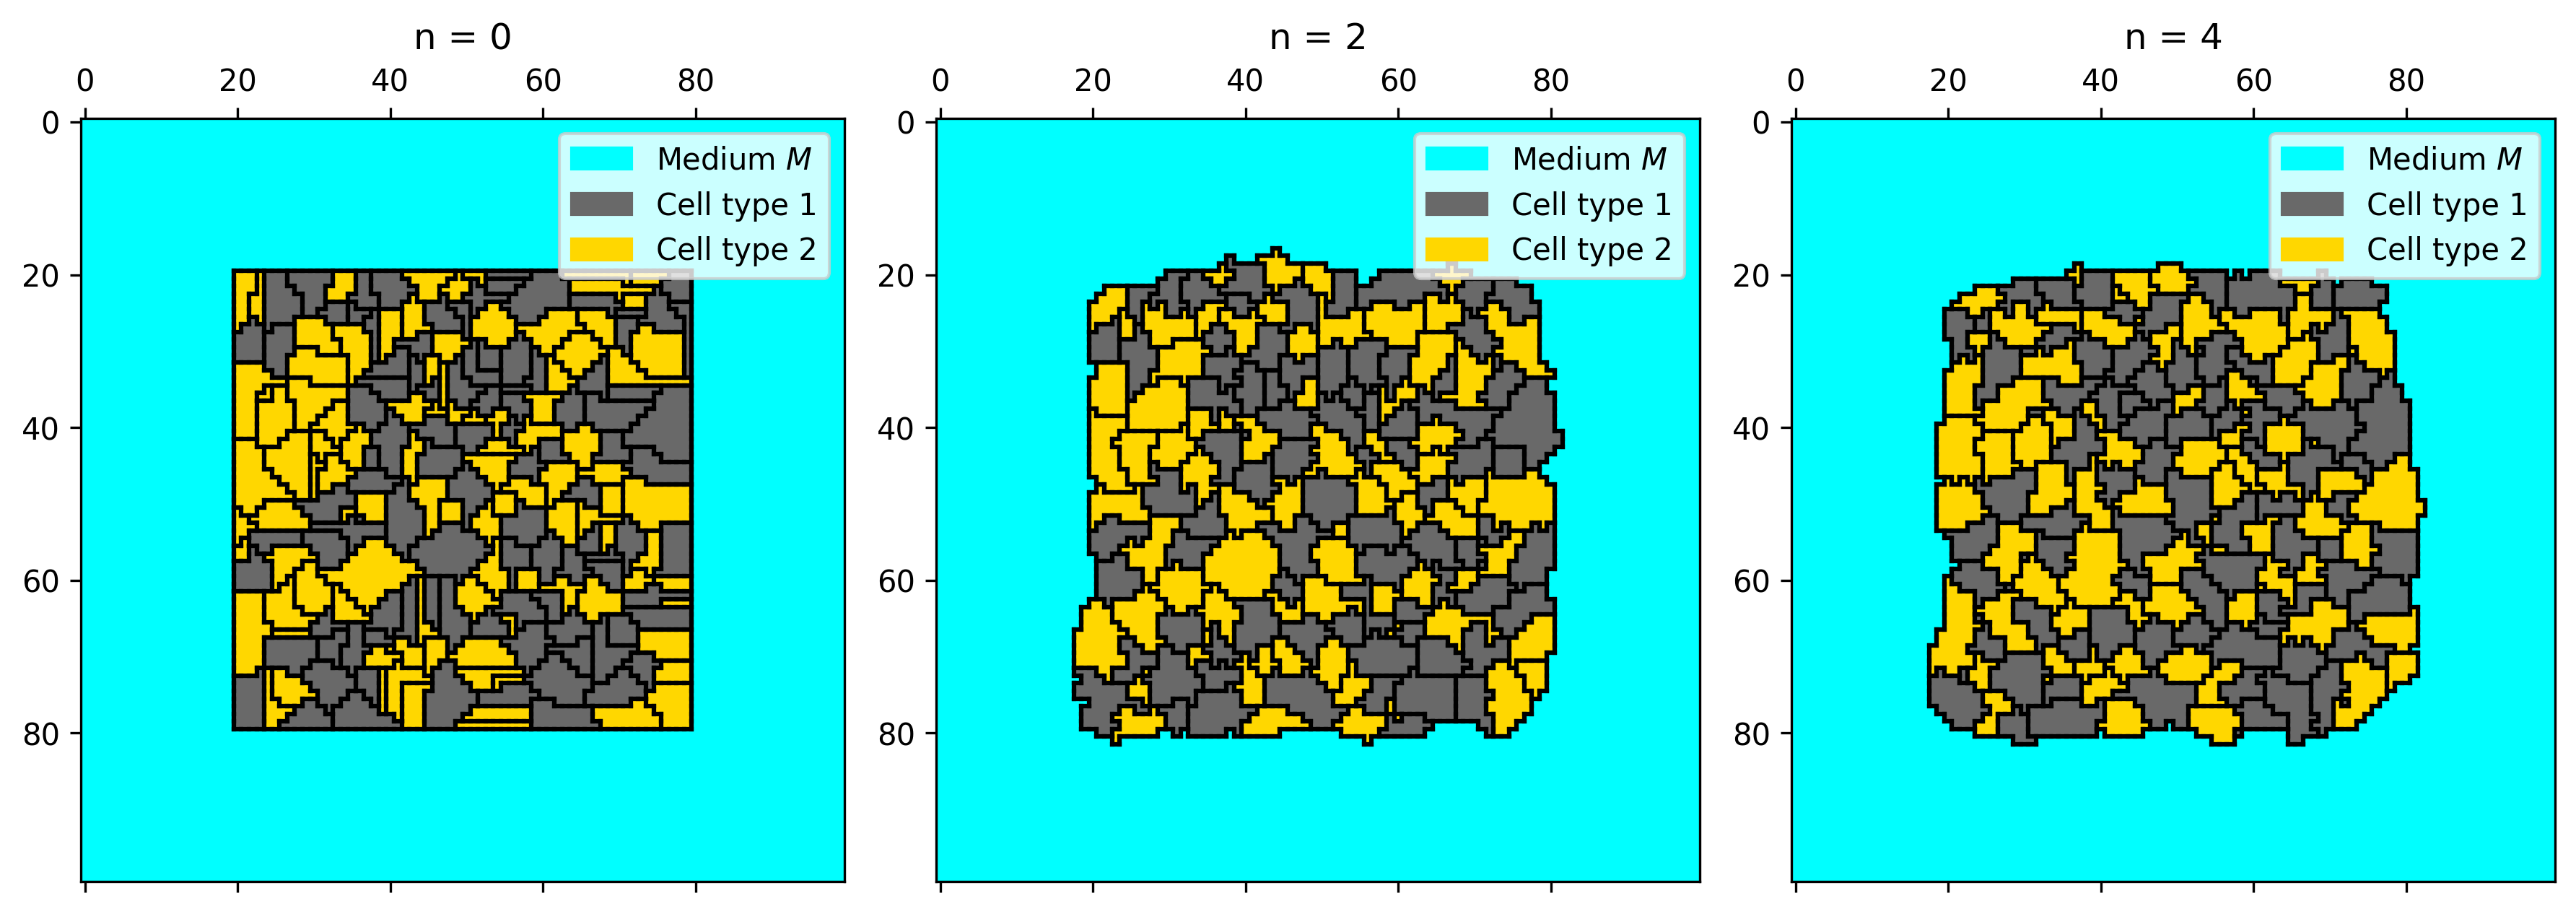

In [26]:
np.random.seed(42) # TODO: remove if not needed
return_metrics_at = [0, 2, 4]
grid, metrics = Cellular_Potts_model(J=J, A=A, n_MCS=n_MCS, T=T, n_cells=n_cells, n_types=n_types, padding=padding, nx=nx, K=k, lam_vol=lam_vol, return_metrics_at=return_metrics_at)
grids = metrics['grids']
fig = sequence_plot(return_metrics_at, grids, n_types, MCS)
fig.savefig(f'{MEDIA_PATH}/cellular_potts_paper.png', bbox_inches='tight')
fig.show()

Animation

In [ ]:
frames = 300
fps = 60
n_MCS = 300
assert n_MCS % frames == 0 # Ensure that the frames are evenly distributed
return_metrics_at = np.arange(0, n_MCS, n_MCS//frames)
grid, metrics = Cellular_Potts_model(J, A, n_MCS=n_MCS, T=T, n_cells=n_cells, n_types=n_types, padding=padding, nx=nx, K=k, lam_vol=lam_vol, return_metrics_at=return_metrics_at)
grids = metrics['grids']
anim = animate_grids(grids, return_metrics_at, fps, n_types)
anim.save(f'{MEDIA_PATH}/animated_cellular_potts_paper_{n_MCS}MCS_{frames}_frames_{fps}_fps.gif', writer='ffmpeg')

Update using some new parameters i.e. simulate for n_types = 3 and use new custom padding during initialization + generalized plotting for this non-trivial case

In [ ]:
n_types = 3
padding = 15
J = np.array([
    [J_MM, J_dM, J_lM, J_MM],
    [J_dM, J_dd, J_ld, J_dM],
    [J_lM, J_ld, J_ll, J_lM],
    [J_MM, J_dM, J_lM, J_MM],
])
n_MCS = 4
A = np.zeros(4)
A[1:] = 20

Grids shape
(3, 100, 100)


Simulating:   0%|          | 0/640000 [00:00<?, ?step/s]

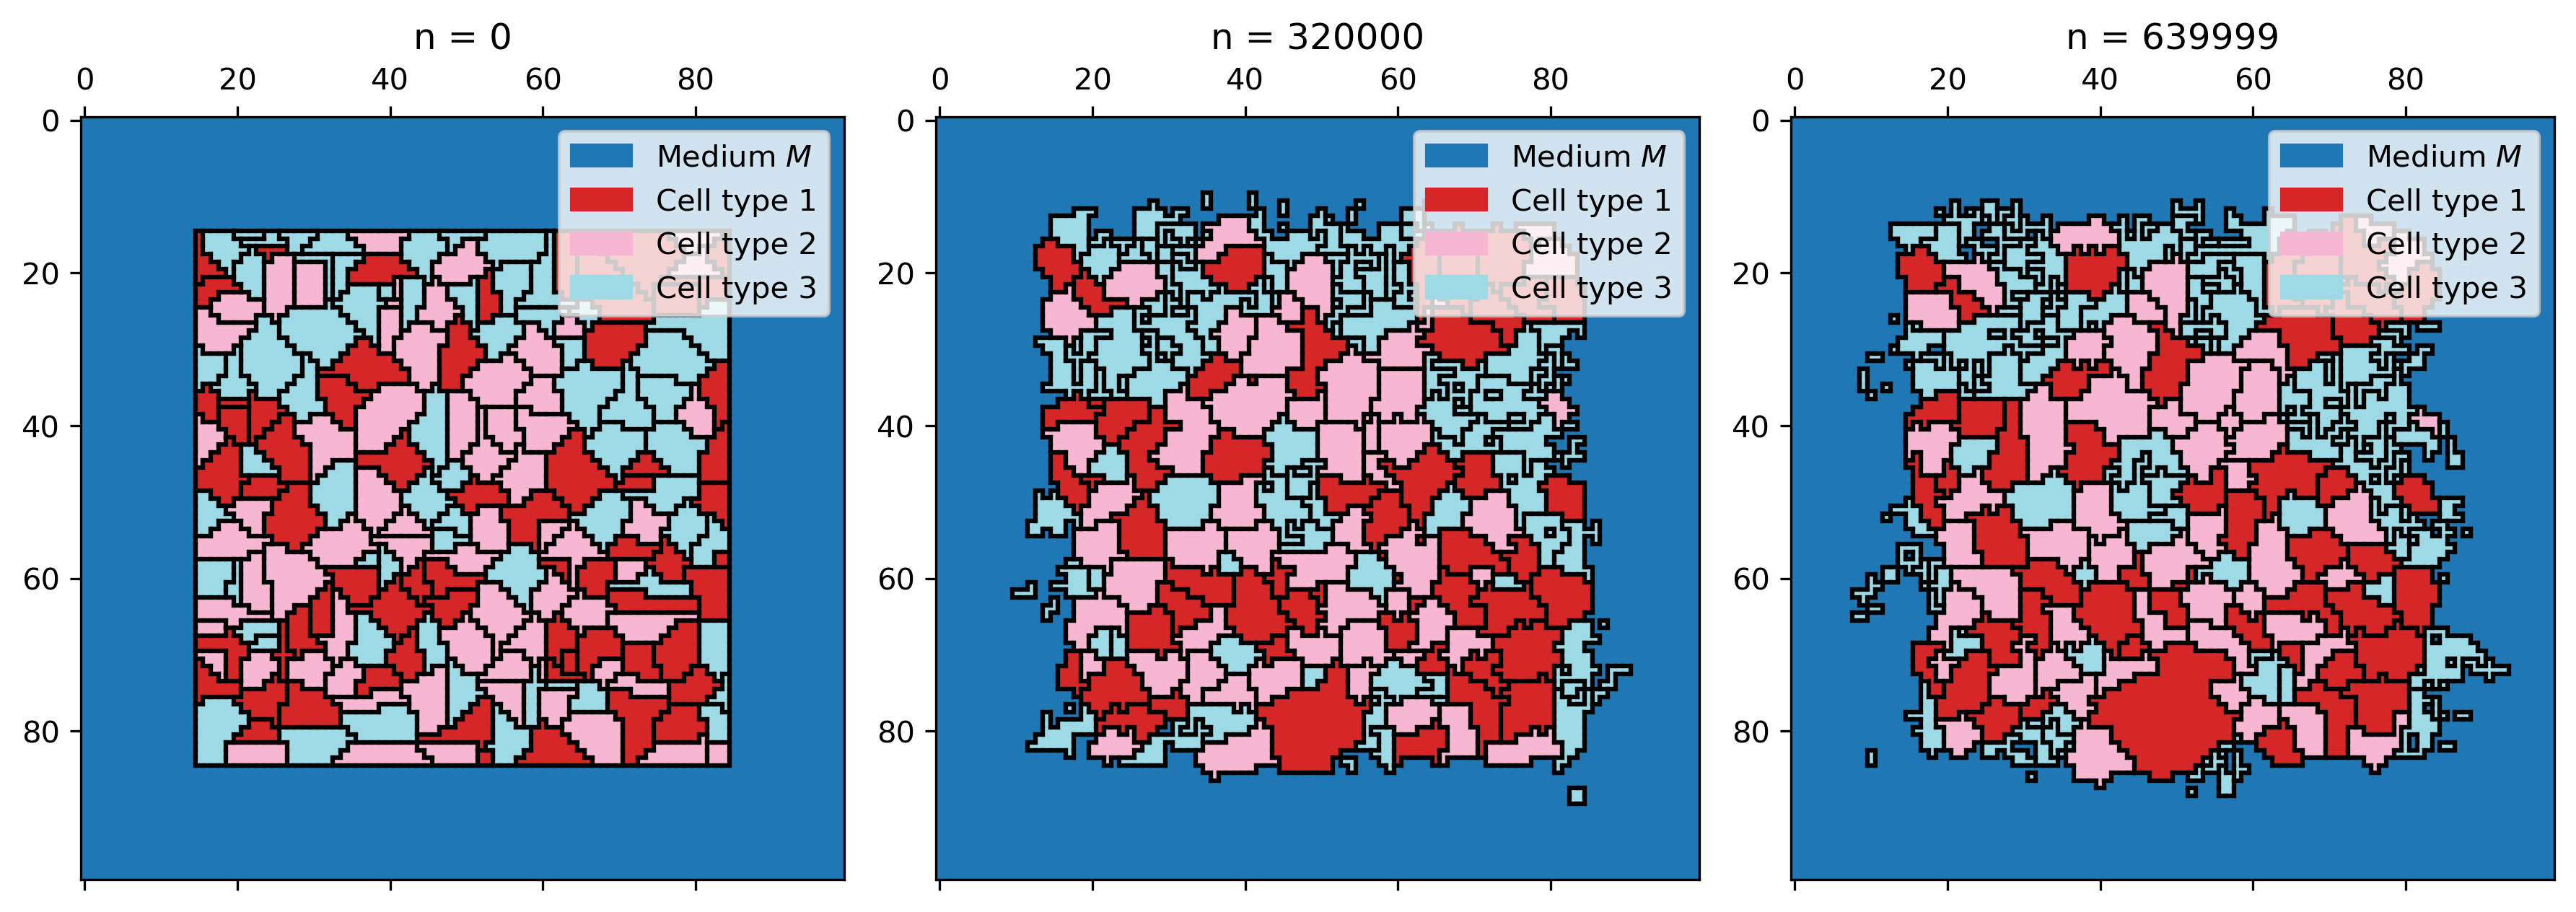

In [ ]:
np.random.seed(42) # TODO: remove if not needed
return_metrics_at = [0, 2, 4]
grid, metrics = Cellular_Potts_model(J=J, A=A, n_MCS=n_MCS, T=T, n_cells=n_cells, n_types=n_types, padding=padding, nx=nx, K=k, lam_vol=lam_vol, return_metrics_at=return_metrics_at)
grids = metrics['grids']
fig = sequence_plot(return_metrics_at, grids, n_types, MCS)
fig.savefig(f'{MEDIA_PATH}/cellular_potts_introduce_4_types.png', bbox_inches='tight')

Update parameters again to try new grid sizes

In [ ]:
nx = 200
MCS = 16*nx**2
n_MCS = 4

Simulate and plot

Grids shape
(3, 200, 200)


Simulating:   0%|          | 0/2560000 [00:00<?, ?step/s]

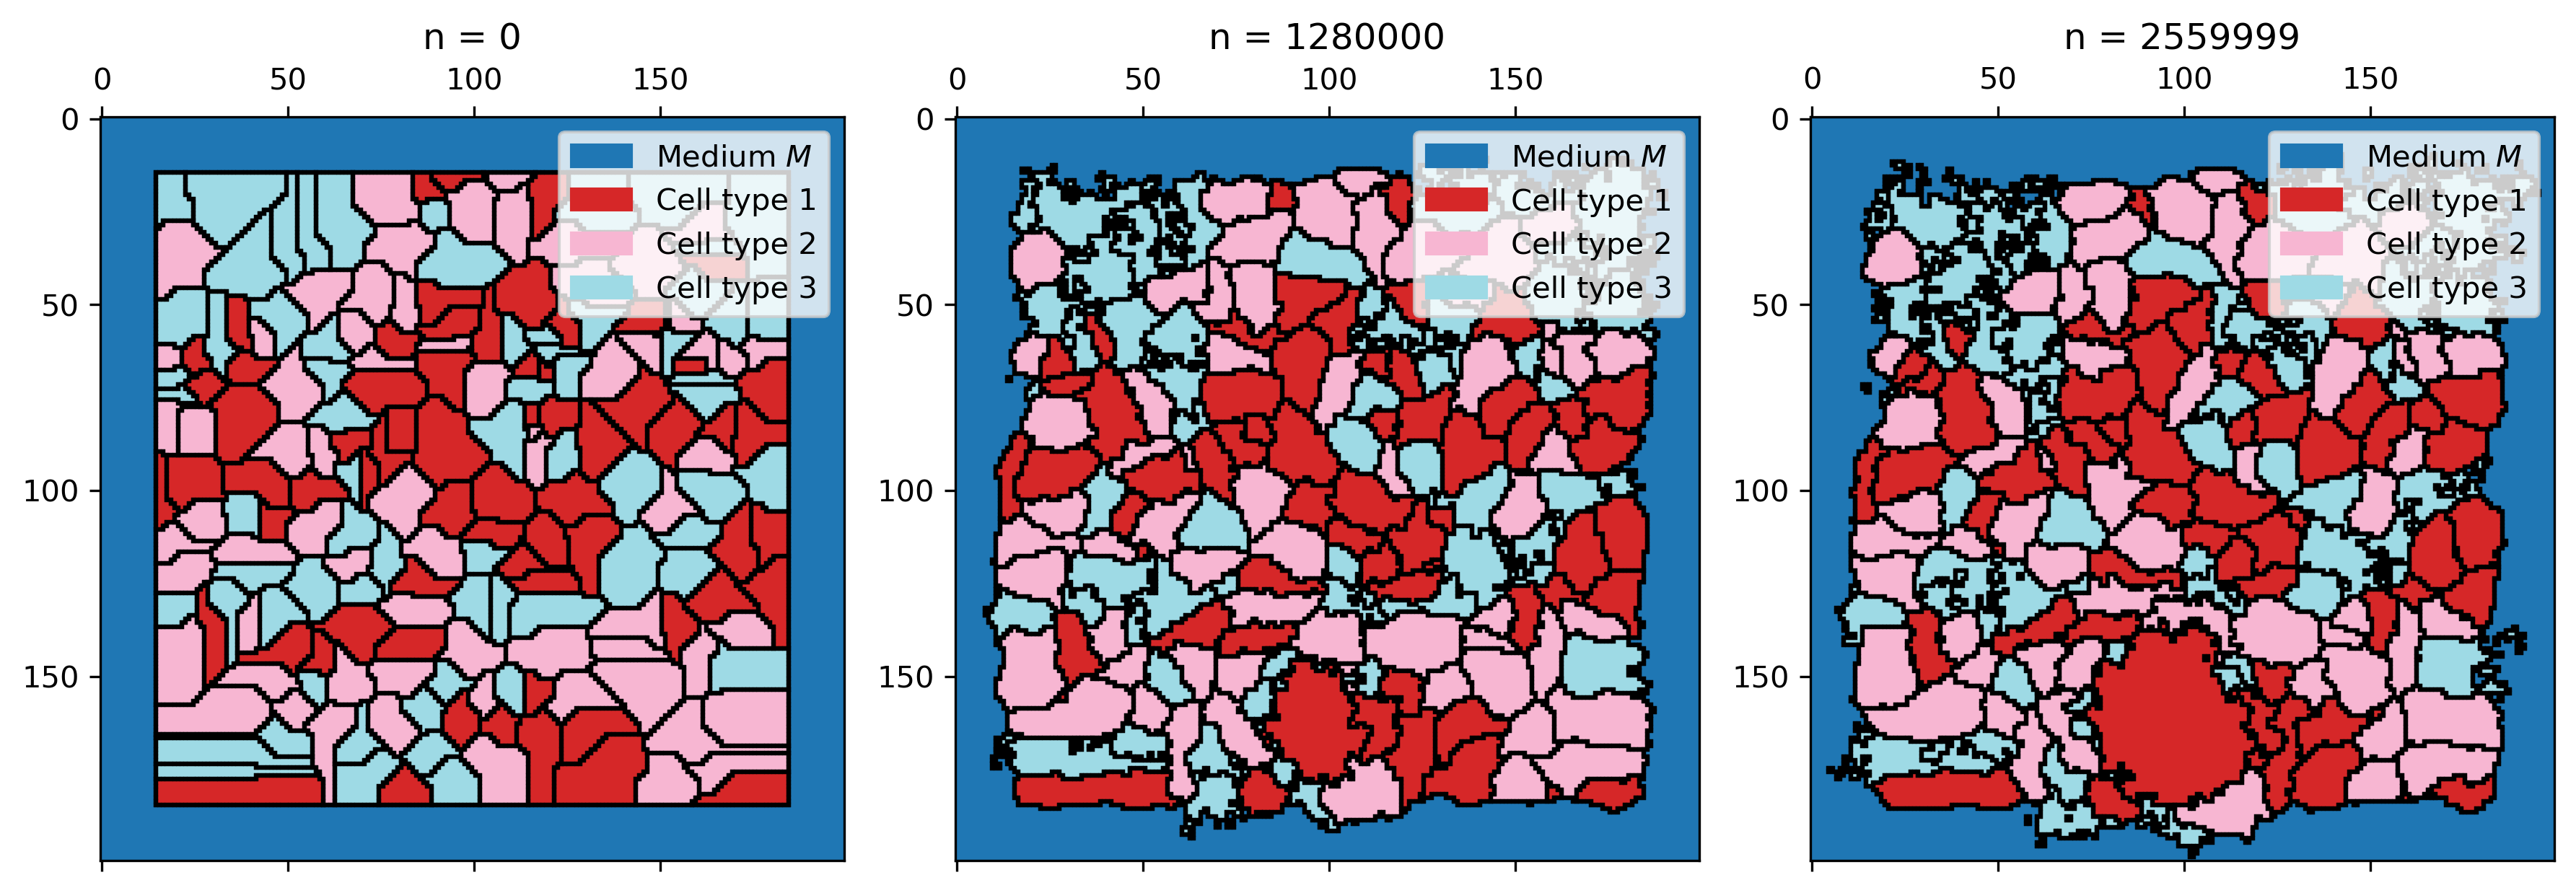

In [ ]:
np.random.seed(42) # TODO: remove if not needed
return_metrics_at = [0, 2, 4]
grid, metrics = Cellular_Potts_model(J=J, A=A, n_MCS=n_MCS, T=T, n_cells=n_cells, padding=padding, n_types=n_types, nx=nx, K=k, lam_vol=lam_vol, return_metrics_at=return_metrics_at)
grids = metrics['grids']
fig = sequence_plot(return_metrics_at, grids, n_types, MCS)
fig.savefig(f'{MEDIA_PATH}/cellular_potts_4_types_introduce_nx_200.png', bbox_inches='tight')

Grids shape
(301, 200, 200)


Simulating:   0%|          | 0/12800000 [00:00<?, ?step/s]

Rendering:   0%|          | 0/301 [00:00<?, ?frames/s]

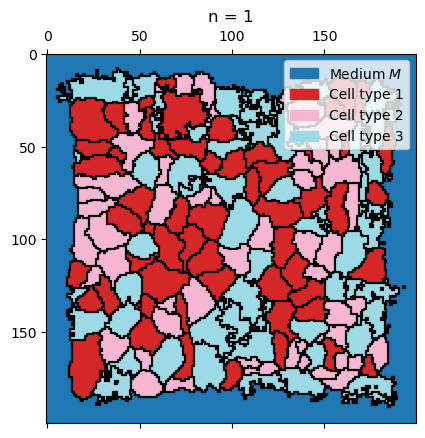

In [ ]:
frames = 300
fps = 60
n_MCS = 300
assert n_MCS % frames == 0 # Ensure that the frames are evenly distributed
return_metrics_at = np.arange(0, n_MCS, n_MCS//frames)
grids = Cellular_Potts_model(J=J, A=A, n_MCS=n_MCS, T=T, n_cells=n_cells, padding=padding, n_types=n_types, nx=nx, K=k, lam_vol=lam_vol, return_metrics_at=return_metrics_at)[1]['grids']
anim = animate_grids(grids, return_metrics_at, fps, n_types)
anim.save(f'{MEDIA_PATH}/animated_cellular_potts_4_types_nx_200_{frames}_frames_{fps}_fps.gif', writer='ffmpeg')